In [1]:
!pip install pandas;
!pip install scipy;
!pip install tqdm
import pandas as pd;
from pathlib import Path;
import numpy as np;
from tqdm import tqdm;


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
data_dir = Path("data")
outbreak = pd.read_csv(data_dir / "OutbreaksData.csv")
outbreak.head()

,Unnamed: 0,Country,iso2,iso3,Year,icd10n,icd103n,icd104n,icd10c,icd103c,icd104c,icd11c1,icd11c2,icd11c3,icd11l1,icd11l2,icd11l3,Disease,DONs,Definition
0,1,Afghanistan,AF,AFG,2000,Arthropod-borne viral fevers and viral haemorr...,Unspecified viral haemorrhagic fever,Unspecified viral haemorrhagic fever,A92-A99,A99,A990,1,D86,1D86,Certain infectious or parasitic diseases,Certain other viral diseases,"Viral haemorrhagic fever, not elsewhere classi...",Unspecified viral haemorrhagic fever,"DON0404, DON0399",NaN
1,2,Afghanistan,AF,AFG,2002,Intestinal infectious diseases,Other gastroenteritis and colitis of infectiou...,Other and unspecified gastroenteritis and coli...,A00-A09,A09,A090,1,A40,1A40,Certain infectious or parasitic diseases,Gastroenteritis or colitis of infectious origin,Gastroenteritis or colitis without specificati...,Infectious gastroenteritis or colitis without ...,DON0607,NaN
2,3,Afghanistan,AF,AFG,1998,Intestinal infectious diseases,Cholera,Classical cholera,A00-A09,A00,A000,1,A00,1A00,Certain infectious or parasitic diseases,Gastroenteritis or colitis of infectious origin,Bacterial intestinal infections,Cholera,"DON0253, DON0249, DON0248",Intestinal infection due to Vibrio cholerae
3,4,Afghanistan,AF,AFG,1999,Codes for special purposes,Provisional assignment of new diseases of unce...,Severe acute respiratory syndrome [SARS],U00-U49,U04,U049,1,D65,1D65,Certain infectious or parasitic diseases,Certain zoonotic viral diseases,Severe acute respiratory syndrome,Severe acute respiratory syndrome,DON0294,"A disease of the respiratory system, caused by..."
4,5,Afghanistan,AF,AFG,2000,Intestinal infectious diseases,Cholera,Classical cholera,A00-A09,A00,A000,1,A00,1A00,Certain infectious or parasitic diseases,Gastroenteritis or colitis of infectious origin,Bacterial intestinal infections,Cholera,DON0413,Intestinal infection due to Vibrio cholerae


In [3]:
zoonotic = [
    'Unspecified viral haemorrhagic fever',
    'Severe acute respiratory syndrome [SARS]',
    'Influenza due to identified zoonotic or pandemic influenza virus',
    'Dengue, unspecified',
    'Leishmaniasis, unspecified',
    'West Nile virus infection',
    'Plague, unspecified',
    'Middle East respiratory syndrome coronavirus [MERS-CoV]',
    'Yellow fever, unspecified',
    'Hantavirus (cardio-)pulmonary syndrome',
    'Chikungunya virus disease',
    'Listeriosis, unspecified',
    'Legionnaires disease',
    'Acute hepatitis A',
    'Zika virus disease',
    'Lassa fever',
    'Acute hepatitis E',
    'Monkeypox',
    'Leptospirosis, unspecified',
    'Rift Valley fever',
    'Ebola virus disease',
    'Marburg virus disease',
    'Anthrax, unspecified',
    'Rabies, unspecified',
    'Salmonella infection, unspecified',
    'Tularaemia, unspecified',
    'Venezuelan equine fever',
    'Coccidioidomycosis, unspecified',
    'Haemorrhagic fever with renal syndrome',
    'St Louis encephalitis',
    'Bubonic plague'
]
# We are not including covid, just adding an outbreak in China since this was the animal to human part


In [4]:
filtered_df = outbreak[outbreak['icd103n'].isin(zoonotic)]

In [5]:
filtered_df['Year'].unique()

array([2000, 2009, 1998, 2014, 2004, 2005, 2010, 2016, 2017, 2006, 2003,
       2008, 2012, 2011, 1996, 2002, 2020, 2021, 2013, 2007, 2018, 2015,
       2001, 1999, 1997, 2019, 2022], dtype=int64)

In [6]:
final_outbreak = filtered_df[['Year', 'Country', 'icd103n']]
final_outbreak._append({"Year": 2020, "Country": "China", 'icd103n': 'COVID-19, virus identified'}, ignore_index=True)

,Year,Country,icd103n
0,2000,Afghanistan,Unspecified viral haemorrhagic fever
1,2009,Afghanistan,Influenza due to identified zoonotic or pandem...
2,1998,Afghanistan,Unspecified viral haemorrhagic fever
3,2009,Albania,Influenza due to identified zoonotic or pandem...
4,2009,Algeria,Influenza due to identified zoonotic or pandem...
...,...,...,...
546,2014,Yemen,Severe acute respiratory syndrome [SARS]
547,2009,Zambia,Influenza due to identified zoonotic or pandem...
548,1999,Zimbabwe,Unspecified viral haemorrhagic fever
549,2009,Zimbabwe,Influenza due to identified zoonotic or pandem...


In [7]:
country_data_raw = pd.read_csv(data_dir / "country_data" / "country_data.csv")
country_data_raw.columns

Index(['Series Name', 'Series Code', 'Country Name', 'Country Code',
       '1960 [YR1960]', '1961 [YR1961]', '1962 [YR1962]', '1963 [YR1963]',
       '1964 [YR1964]', '1965 [YR1965]', '1966 [YR1966]', '1967 [YR1967]',
       '1968 [YR1968]', '1969 [YR1969]', '1970 [YR1970]', '1971 [YR1971]',
       '1972 [YR1972]', '1973 [YR1973]', '1974 [YR1974]', '1975 [YR1975]',
       '1976 [YR1976]', '1977 [YR1977]', '1978 [YR1978]', '1979 [YR1979]',
       '1980 [YR1980]', '1981 [YR1981]', '1982 [YR1982]', '1983 [YR1983]',
       '1984 [YR1984]', '1985 [YR1985]', '1986 [YR1986]', '1987 [YR1987]',
       '1988 [YR1988]', '1989 [YR1989]', '1990 [YR1990]', '1991 [YR1991]',
       '1992 [YR1992]', '1993 [YR1993]', '1994 [YR1994]', '1995 [YR1995]',
       '1996 [YR1996]', '1997 [YR1997]', '1998 [YR1998]', '1999 [YR1999]',
       '2000 [YR2000]', '2001 [YR2001]', '2002 [YR2002]', '2003 [YR2003]',
       '2004 [YR2004]', '2005 [YR2005]', '2006 [YR2006]', '2007 [YR2007]',
       '2008 [YR2008]', '2009 [

In [8]:
filtered_columns = ['Series Name', 'Country Name', '1996 [YR1996]', '1997 [YR1997]', '1998 [YR1998]', '1999 [YR1999]',
       '2000 [YR2000]', '2001 [YR2001]', '2002 [YR2002]', '2003 [YR2003]',
       '2004 [YR2004]', '2005 [YR2005]', '2006 [YR2006]', '2007 [YR2007]',
       '2008 [YR2008]', '2009 [YR2009]', '2010 [YR2010]', '2011 [YR2011]',
       '2012 [YR2012]', '2013 [YR2013]', '2014 [YR2014]', '2015 [YR2015]',
       '2016 [YR2016]', '2017 [YR2017]', '2018 [YR2018]', '2019 [YR2019]',
       '2020 [YR2020]', '2021 [YR2021]', '2022 [YR2022]']
country_data = country_data_raw[filtered_columns].iloc[:-5] # Getting rid of data description at the bottom

In [9]:
# Making custom interpolation function since np's is being weird
def convert_values(series):
    return [np.nan if num == '..' else pd.to_numeric(num) for num in series]

In [10]:
# converting strings to nan
dropped_cols = ['Series Name', 'Country Name'] 
df_subset = country_data.drop(columns=dropped_cols)
df_filled = df_subset.apply(convert_values)
print("Converted non numerics to nan")
country_final = pd.concat([country_data[dropped_cols], df_filled], axis=1)
country_final.head()

Converted non numerics to nan


,Series Name,Country Name,1996 [YR1996],1997 [YR1997],1998 [YR1998],1999 [YR1999],2000 [YR2000],2001 [YR2001],2002 [YR2002],2003 [YR2003],...,2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022]
0,"Completeness of birth registration, rural (%)",Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.3,...,NaN,NaN,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Completeness of birth registration, rural (%)",Africa Eastern and Southern,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Completeness of birth registration, rural (%)",Africa Western and Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Completeness of birth registration, rural (%)",Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,98.4,NaN,NaN,NaN,NaN
4,"Completeness of birth registration, rural (%)",Algeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,99.5,NaN,NaN,NaN,NaN,NaN,99.6,NaN,NaN,NaN


In [11]:
#
final_outbreak_ml = final_outbreak[['Year', 'Country']]
final_outbreak_ml = final_outbreak_ml.groupby(['Country', 'Year']).size().unstack(fill_value=0)
final_outbreak_ml.head()                                     

Year,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Albania,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Algeria,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
American Samoa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Andorra,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Normalize the two tables so that the years and countries match up

In [12]:
# Are there any mismatches between the two?
countries1 = np.array([str(country) for country in country_final['Country Name'].unique()])
countries2 = np.array(final_outbreak_ml.index)

In [13]:
np.setdiff1d(countries1, countries2)

array(['Africa Eastern and Southern', 'Africa Western and Central',
       'Arab World', 'Bahamas, The', 'Belarus', 'Benin', 'Bolivia',
       'British Virgin Islands', 'Burkina Faso', 'Caribbean small states',
       'Central Europe and the Baltics', 'Channel Islands', 'Comoros',
       'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", 'Curacao',
       'Early-demographic dividend', 'East Asia & Pacific',
       'East Asia & Pacific (IDA & IBRD countries)',
       'East Asia & Pacific (excluding high income)', 'Egypt, Arab Rep.',
       'Equatorial Guinea', 'Eritrea', 'Euro area',
       'Europe & Central Asia',
       'Europe & Central Asia (IDA & IBRD countries)',
       'Europe & Central Asia (excluding high income)', 'European Union',
       'Faroe Islands', 'Fragile and conflict affected situations',
       'Gambia, The', 'Gibraltar', 'Greenland', 'Guinea-Bissau',
       'Heavily indebted poor countries (HIPC)', 'High income',
       'Hong Kong SAR, China', 'IBRD only', 'IDA & 

In [14]:
np.setdiff1d(countries2, countries1)


array(['Bahamas', 'Bolivia (Plurinational State of)',
       'Bonaire Sint Eustatius and Saba', 'Congo',
       'Congo Democratic Republic of the', 'Cook Islands', 'Curaçao',
       "Côte d'Ivoire", 'Egypt', 'Falkland Islands (Malvinas)',
       'French Guiana', 'Guadeloupe', 'Guernsey', 'Hong Kong',
       'Iran (Islamic Republic of)', 'Jersey',
       "Korea (Democratic People's Republic of)", 'Korea Republic of',
       "Lao People's Democratic Republic", 'Martinique',
       'Micronesia (Federated States of)', 'Moldova Republic of',
       'Palestine State of', 'Réunion', 'Saint Kitts and Nevis',
       'Saint Lucia', 'Saint Martin (French part)',
       'Saint Vincent and the Grenadines', 'Slovakia',
       'Tanzania United Republic of', 'Turkey',
       'United Kingdom of Great Britain and Northern Ireland',
       'United States of America', 'Venezuela (Bolivarian Republic of)',
       'Viet Nam', 'Virgin Islands (British)', 'Wallis and Futuna',
       'Yemen'], dtype=object)

In [15]:
def update_name(name):
    lookup = {
        "Bolivia (Plurinational State of)": "Bolivia",
        "United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
        "Turkey": "Turkiye",
        "United States of America": "United States",
        "Viet Nam": "Vietnam",
        "Yemen": "Yemen, Rep.",
        "Egypt": "Egypt, Arab Rep.",
        "Hong Kong": "Hong Kong SAR, China",
        "Iran (Islamic Republic of)": "Iran, Islamic Rep.",
        "Venezuela (Bolivarian Republic of)": "Venezuela, RB",
        "Congo Democratic Republic of the": "Congo, Dem. Rep.",
        "Korea Republic of": "Korea, Rep."
    }
    if name in lookup:
        return lookup[name]
    else:
        return name

final_outbreak_ml.index = pd.Series(final_outbreak_ml.index).apply(update_name)

In [16]:
# Subset world data for only countries with outbreaks
country_norm = country_final[country_final['Country Name'].isin(final_outbreak_ml.index)]
outbreak_norm = final_outbreak_ml.loc[country_norm['Country Name'].unique()]

## Merging the two tables together
Now that the tables have the same countries, we can try to merge them together

In [17]:
country_long = country_norm.melt(id_vars=["Series Name", "Country Name"], var_name="year", value_name="value")
def extract_year(year_str):
    return year_str.split(" ")[0]
country_long['year'] = country_long['year'].apply(extract_year)
country_long.head()

,Series Name,Country Name,year,value
0,"Completeness of birth registration, rural (%)",Afghanistan,1996,NaN
1,"Completeness of birth registration, rural (%)",Albania,1996,NaN
2,"Completeness of birth registration, rural (%)",Algeria,1996,NaN
3,"Completeness of birth registration, rural (%)",American Samoa,1996,NaN
4,"Completeness of birth registration, rural (%)",Andorra,1996,NaN


### Dealing with np.nan
A lot of these values are missing so in order to preserve trends, we want to fill in all of the values for a country and statstic to be the mean of that statistic for that country. Otherwise label it as 0 so that it is not weighted in the model.

In [18]:
means = country_long.groupby(['Series Name', 'Country Name'])['value'].transform('mean')
# If there is a mean, fill in all the na's with that mean
country_long['value'] = country_long['value'].fillna(means)
# Otherwise, fill all blank values with 0
country_long['value'] = country_long['value'].fillna(0)

In [19]:
country_long.head(10)

,Series Name,Country Name,year,value
0,"Completeness of birth registration, rural (%)",Afghanistan,1996,24.466667
1,"Completeness of birth registration, rural (%)",Albania,1996,98.266667
2,"Completeness of birth registration, rural (%)",Algeria,1996,99.433333
3,"Completeness of birth registration, rural (%)",American Samoa,1996,0.000000
4,"Completeness of birth registration, rural (%)",Andorra,1996,0.000000
5,"Completeness of birth registration, rural (%)",Angola,1996,19.700000
6,"Completeness of birth registration, rural (%)",Antigua and Barbuda,1996,0.000000
7,"Completeness of birth registration, rural (%)",Argentina,1996,0.000000
8,"Completeness of birth registration, rural (%)",Armenia,1996,98.100000
9,"Completeness of birth registration, rural (%)",Aruba,1996,0.000000


In [20]:
outbreak_long = outbreak_norm.reset_index().rename(columns={"index":"Country"})
outbreak_long.head()

Year,Country,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Afghanistan,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Albania,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Algeria,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,American Samoa,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Andorra,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# Lastly, make sure the column names match exactly
outbreak_long = outbreak_long.reset_index(drop=True)
outbreak_long = outbreak_long.melt(id_vars="Country", var_name="Year", value_name="Outbreaks")
outbreak_long["Value"] = outbreak_long["Outbreaks"]
outbreak_long["Statistic"] = ["Outbreaks" for num in outbreak_long["Value"]]
outbreak_long.drop(columns=["Outbreaks"], inplace=True)
outbreak_long.head()

,Country,Year,Value,Statistic
0,Afghanistan,1996,0,Outbreaks
1,Albania,1996,0,Outbreaks
2,Algeria,1996,0,Outbreaks
3,American Samoa,1996,0,Outbreaks
4,Andorra,1996,0,Outbreaks


In [22]:
#Make sure they have the same column names
country_long.columns = ["Statistic", "Country", "Year", "Value"]

In [23]:
training_df = pd.concat([outbreak_long, country_long])
training_df['Year'] = training_df['Year'].astype(int)
training_df.head()

,Country,Year,Value,Statistic
0,Afghanistan,1996,0.0,Outbreaks
1,Albania,1996,0.0,Outbreaks
2,Algeria,1996,0.0,Outbreaks
3,American Samoa,1996,0.0,Outbreaks
4,Andorra,1996,0.0,Outbreaks


## Add adjacency column
Outbreaks don't occur very often so we want there to be some representation of adjacency in the data, especially since we are training each year independently. We want to add a column to capture this.

In [24]:
#
outbreak_df = training_df[training_df['Statistic'] == 'Outbreaks']
new_df = pd.DataFrame({"Country": outbreak_df["Country"], "Year": outbreak_df["Year"], "Value": np.zeros(len(outbreak_df)), "Statistic": ["Recent Outbreak"] * len(outbreak_df)})
only_outbreaks = outbreak_df[outbreak_df['Value'] > 0]

# function for the year range, if there is an outbreak in a year then we don't necessarily have recent outbreak be true
# otherwise the model might weigh it unusually highly
def generate_numbers(input_number):
    return [i for i in range(input_number + 1, min(input_number + 6, 2023))]
    
for row in tqdm(only_outbreaks.itertuples(index=False)):
    years = generate_numbers(row.Year)
    country = row.Country
    new_df.loc[(new_df['Year'].isin(years)) & (new_df['Country'] == country), 'Value'] = 1

combined = pd.concat([training_df, new_df])

509it [00:00, 2037.49it/s]


## Pivot table for ML training
Typically ML classes require us to have each observation have the several values (in this case the value of each statistic) in each row. For this we need to make a pivot table where each row is a country/year pair, and the columns are the values of the statistics  |  |

In [25]:
combined["Country_Year"] = combined["Country"] + "_" + combined["Year"].astype(str)
pivot_df = combined.pivot(index=["Country_Year"], columns="Statistic", values="Value")
pivot_df.index.name = None
pivot_df.head()

Statistic,"Completeness of birth registration, rural (%)","Hospital beds (per 1,000 people)",Human capital index (HCI) (scale 0-1),"Human capital index (HCI), male (scale 0-1)",Low-birthweight babies (% of births),"Number of surgical procedures (per 100,000 population)",Outbreaks,People practicing open defecation (% of population),People using at least basic drinking water services (% of population),People using at least basic sanitation services (% of population),People using safely managed sanitation services (% of population),People with basic handwashing facilities including soap and water (% of population),"Physicians (per 1,000 people)",Prevalence of undernourishment (% of population),Recent Outbreak,Rural population (% of total population),Rural population growth (annual %),Rural poverty headcount ratio at national poverty lines (% of rural population),"Specialist surgical workforce (per 100,000 population)"
Afghanistan_1996,24.466667,0.432222,0.394258,0.403766,0.0,229.0,0.0,17.557965,52.439123,37.452266,0.0,41.150033,0.229435,28.615,0.0,78.286,3.988129,0.0,0.03
Afghanistan_1997,24.466667,0.432222,0.394258,0.403766,0.0,229.0,0.0,17.557965,52.439123,37.452266,0.0,41.150033,0.110000,28.615,0.0,78.195,3.794297,0.0,0.03
Afghanistan_1998,24.466667,0.432222,0.394258,0.403766,0.0,229.0,1.0,17.557965,52.439123,37.452266,0.0,41.150033,0.229435,28.615,0.0,78.105,3.767769,0.0,0.03
Afghanistan_1999,24.466667,0.432222,0.394258,0.403766,0.0,229.0,0.0,17.557965,52.439123,37.452266,0.0,41.150033,0.229435,28.615,1.0,78.014,3.961297,0.0,0.03
Afghanistan_2000,24.466667,0.300000,0.394258,0.403766,0.0,229.0,1.0,25.968485,27.441856,20.970919,0.0,41.150033,0.229435,28.615,1.0,77.922,1.325806,0.0,0.03


## Training the model
We are going to train a few classification models to see which fits the data the best. If the initial results look good, we will move onto k-fold validation and if the results still look good we will do a grid search to determine the best hyperparameters for the model.

### Random Forest Classifier

In [26]:
!pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
pivot_df['Outbreaks'] = (pivot_df['Outbreaks'] > 0).astype(int) # setting this up as a classification problem

# split up our features and target
scaler = StandardScaler()
X = pivot_df.drop('Outbreaks', axis=1)
X_scaled = scaler.fit_transform(X)
X = scaler.fit_transform(X)
y = pivot_df['Outbreaks']

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
feature_importances = clf.feature_importances_

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]  # Probability estimates, our "risk score" in other words

forest_results = clf.predict_proba(X_scaled)[:, 1]

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Feature importance scores:\n", feature_importances)

Accuracy: 0.8849372384937239
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94      1292
           1       0.27      0.09      0.14       142

    accuracy                           0.88      1434
   macro avg       0.59      0.53      0.54      1434
weighted avg       0.84      0.88      0.86      1434

Feature importance scores:
 [0.02055577 0.07543737 0.04068097 0.03570252 0.07312594 0.01897955
 0.05487379 0.0870518  0.09347593 0.0782856  0.03473788 0.08243814
 0.0499     0.02641595 0.09595439 0.10290876 0.         0.02947564]


These results appear to be decent. Of course, it's not very accurately predicting when there will be an outbreak, but that is because only a small fraction of outbreaks occur in each country in each year, so it's understandable that when it **does** predict an outbreak, there is a low likelihood that it is correct. That said, this is kind of expected.

### Random Forest Classifier Validation
We had a training set and a target set, but we want to get put our results under a microscope. We need to do some k-fold cross validation

In [28]:
from sklearn.model_selection import cross_val_score

In [29]:
clf = RandomForestClassifier(random_state=42)

# Number of folds
k = 5

# Perform k-fold cross-validation
cv_scores = cross_val_score(clf, X, y, cv=k)

# Analyze the results
print(f"CV Scores: {cv_scores}")
print(f"Mean CV Score: {np.mean(cv_scores)}")
print(f"Standard Deviation of CV Scores: {np.std(cv_scores)}")

CV Scores: [0.89330544 0.88493724 0.89330544 0.87656904 0.82931937]
Mean CV Score: 0.8754873053078928
Standard Deviation of CV Scores: 0.02390364521678851


Our results look pretty good! Let's make sure we are getting the best results possible by implementing a grid search for parameter tuning. For this we will use f1 score as our scoring metric because we assume that there are very few "actual" positive classifications and so accuracy or precision alone might lead to an imbalanced classification model.

In [30]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
}

# Initialize a Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate on the test set
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Best Parameters: {'max_depth': 20, 'n_estimators': 100}
Best Score: 0.24330895503146827
Test Set Accuracy: 0.8884239888423989
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94      1292
           1       0.32      0.11      0.17       142

    accuracy                           0.89      1434
   macro avg       0.61      0.54      0.55      1434
weighted avg       0.85      0.89      0.86      1434



### Forest Results
Looks like we do pretty well considering the dataset. Next we are going to see how our model stacks up against a basic logistic regression model. This will serve as a sort of "baseline" for our results.

## Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression

In [32]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Initialize and train the Logistic Regression model
# Increasing max_iter and adjusting C if needed
log_reg = LogisticRegression(random_state=42, max_iter=1000, C=1.0, solver='lbfgs')
log_reg.fit(X_train, y_train)

# Coefficients as feature importances
feature_importances = log_reg.coef_[0] #saving this in case this turns out to be the most effective model

y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]  # Probability estimates

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.900976290097629
Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95      1292
           1       0.00      0.00      0.00       142

    accuracy                           0.90      1434
   macro avg       0.45      0.50      0.47      1434
weighted avg       0.81      0.90      0.85      1434



C:\MADS-Capstone\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\MADS-Capstone\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\MADS-Capstone\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
(y_prob > 0.5).sum()

0

Well that's not good... it seems to get a high score because it assumes that there will be no outbreaks at all... ever. This is understandable because of all the years and countries, very few have outbreaks. This might be improved with better scaling but at this point I think we should not use this model.

## KNearest Neighbor

In [34]:
from sklearn.neighbors import KNeighborsClassifier

In [35]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test)[:, 1]  # probability estimates

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8947001394700139
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      1292
           1       0.38      0.11      0.17       142

    accuracy                           0.89      1434
   macro avg       0.65      0.54      0.55      1434
weighted avg       0.86      0.89      0.87      1434



Hey this is actually (marginally) better than our random forest regressor! Let's continue the analysis by using k fold cross validation. Since this is our best model yet, let's also see if we can do some hyperparameter tuning to improve the evaluation statistics. For this we will use f1 score as our scoring metric because we assume that there are very few "actual" positive classifications and so accuracy or precision alone might lead to an imbalanced classification model.

In [36]:
param_grid = {
    'n_neighbors': [2, 3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# evaluate the best one
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)

print("Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
Best Score: 0.26536939145852384
Test Set Accuracy: 0.8947001394700139
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      1292
           1       0.40      0.12      0.18       142

    accuracy                           0.89      1434
   macro avg       0.65      0.55      0.56      1434
weighted avg       0.86      0.89      0.87      1434



## Evaluation Results
It looks like a k nearest neighbor model with manhattan metric, 5 nearest neighbors, and a uniform weight is our most effective model. That said, let's use our best model's predicted probabilities as a sort of "risk score" so that we can use it to visualize the results and predict the trend of outbreaks for each country.

## Shaping Results for Visualizations
Ideally we want a dataframe that is just Country, Year, and Score so that we can fit it onto a map. We also want to apply linear regression to each country to predict the risk score in the next 5 years. We'll do that below before diving into making the visualizations

In [37]:
prob_scores = [tup[1] for tup in best_knn.predict_proba(X_scaled)]
pivot_df['Risk Score'] = prob_scores

In [38]:
pivot_df = pivot_df.reset_index()
pivot_df[['Country', 'Year']] = pivot_df['index'].str.split('_', expand=True)
final_df = pivot_df[['Year', 'Country', 'Risk Score']]
final_df['Year'] = final_df['Year'].astype(int)

C:\Users\samue\AppData\Local\Temp\ipykernel_13224\2495011675.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Year'] = final_df['Year'].astype(int)


In [39]:
from sklearn.linear_model import LinearRegression

future_predictions = pd.DataFrame()

# Iterate over each country
for country in final_df['Country'].unique():
    country_data = final_df[final_df['Country'] == country]
    model = LinearRegression()
    X = country_data[['Year']]
    y = country_data['Risk Score']
    model.fit(X, y)

    # Looking at the next 5 years but we might expand that
    future_years = np.array([[year] for year in range(2023, 2028)])
    predicted_scores = model.predict(future_years)

    # This is the temp dataframe for the predictions
    predictions_df = pd.DataFrame({
        'Year': range(2023, 2028),
        'Country': country,
        'Risk Score': predicted_scores
    })

    # Append predictions to the future_predictions DataFrame
    future_predictions = pd.concat([future_predictions, predictions_df], ignore_index=True)

# Concatenate future predictions with original data
final_df = pd.concat([final_df, future_predictions], ignore_index=True)
final_df[final_df['Risk Score'] < 0] = 0

C:\MADS-Capstone\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\MADS-Capstone\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\MADS-Capstone\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\MADS-Capstone\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\MADS-Capstone\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\MADS-Capstone\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature n

# Visualizations

In [40]:
!pip install plotly
import ipywidgets as widgets
from IPython.display import display
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Country Names
We still need to make sure that our country names match the country names that are expected by the graphing library. Luckily we have a dictionary of the format {code: country} so we will import this, look for differences, and correct the mismatches. 

In [41]:
from iso_dict import iso_codes

In [42]:
country_codes = {v: k for k, v in iso_codes.items()}

In [43]:
# report mismatches
bad_countries = []
for country in final_df['Country'].unique():
    if country not in country_codes:
        bad_countries.append(country)

print(bad_countries)

['Cabo Verde', 'Congo, Dem. Rep.', 'Czechia', 'Egypt, Arab Rep.', 'Eswatini', 'Hong Kong SAR, China', 'Iran, Islamic Rep.', 'Korea, Rep.', 'Kosovo', 'North Macedonia', 'Sint Maarten (Dutch part)', 'Syrian Arab Republic', 'Turkiye', 'United States', 'Venezuela, RB', 'Vietnam', 'Virgin Islands (U.S.)', 'Yemen, Rep.', 0]


In [44]:
correct_countries = {
    'Cabo Verde': 'CPV',
    'Congo, Dem. Rep.': 'COD',
    'Czechia': 'CZE',
    'Egypt, Arab Rep.': 'EGY',
    'Eswatini': 'SWZ',
    'Hong Kong SAR, China': 'HKG',
    'Iran, Islamic Rep.': 'IRN',
    'Korea, Rep.': 'KOR',
    'Kosovo': 'XKX',  # Note: Kosovo uses the "XKX" code as it is not universally recognized
    'North Macedonia': 'MKD',
    'Sint Maarten (Dutch part)': 'SXM',
    'Syrian Arab Republic': 'SYR',
    'Turkiye': 'TUR',
    'United States': 'USA',
    'Venezuela, RB': 'VEN',
    'Vietnam': 'VNM',
    'Virgin Islands (U.S.)': 'VIR',
    'Yemen, Rep.': 'YEM',
}


In [45]:
final_df = final_df[final_df['Country'] != 0] # pretty sure this is just a null entry
country_codes.update(correct_countries)
final_df['Country'] = [country_codes[country] for country in final_df['Country']]

In [46]:
final_df.head()

,Year,Country,Risk Score
0,1996,AFG,0.4
1,1997,AFG,0.4
2,1998,AFG,0.4
3,1999,AFG,0.0
4,2000,AFG,0.2


# Example heatmap

In [47]:
!pip install pandas plotly ipywidgets
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.express as px
pyo.init_notebook_mode(connected=True)


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [48]:
# Example DataFrame
data = {
    'Year': [2020, 2020, 2021, 2021],
    'Country': ['USA', 'CAN', 'USA', 'CAN'],
    'Risk Score': [0.5, 0.3, 0.6, 0.4]
}
df = pd.DataFrame(data)

In [60]:
import plotly.express as px
df = final_df

def create_heatmap(year):
    filtered_df = df[df['Year'] == year]
    
    fig = px.choropleth(
        filtered_df,
        locations="Country",
        color="Risk Score",
        hover_name="Country",
        color_continuous_scale=px.colors.sequential.Plasma,
        locationmode='ISO-3',
        range_color=(0, 1)
    )
    fig.update_layout(
        title=f'Risk Score Heatmap for {year}',
        geo=dict(
            showframe=False,
            showcoastlines=False,
            projection_type='equirectangular'
        )
    )
    fig.show()


IntSlider(value=2000, continuous_update=False, description='Year:', max=2027, min=2000)

Output()

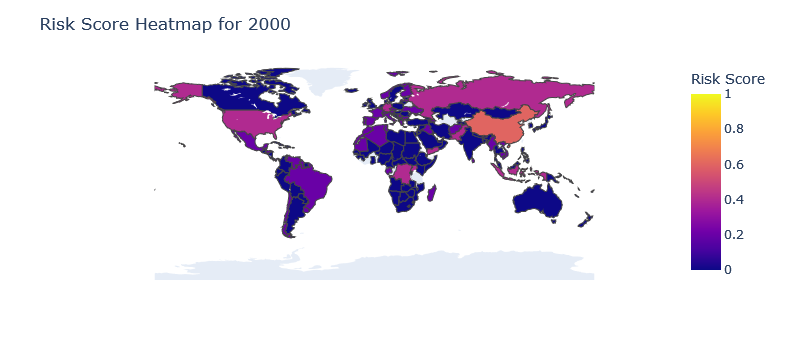

In [61]:
import ipywidgets as widgets
from IPython.display import display


# Assuming df is your DataFrame and it has a 'Year' column
year_slider = widgets.IntSlider(
    value=2000, min=2000, max=2027, step=1,
    description='Year:', continuous_update=False
)

# Output widget
output = widgets.Output()

# Callback function using output widget
def on_year_change(change):
    with output:
        output.clear_output(wait=True)  # Clear previous output
        create_heatmap(change.new)  # Generate new output

# Observe slider changes
year_slider.observe(on_year_change, names='value')

# Display widgets
display(year_slider, output)
create_heatmap(2000)


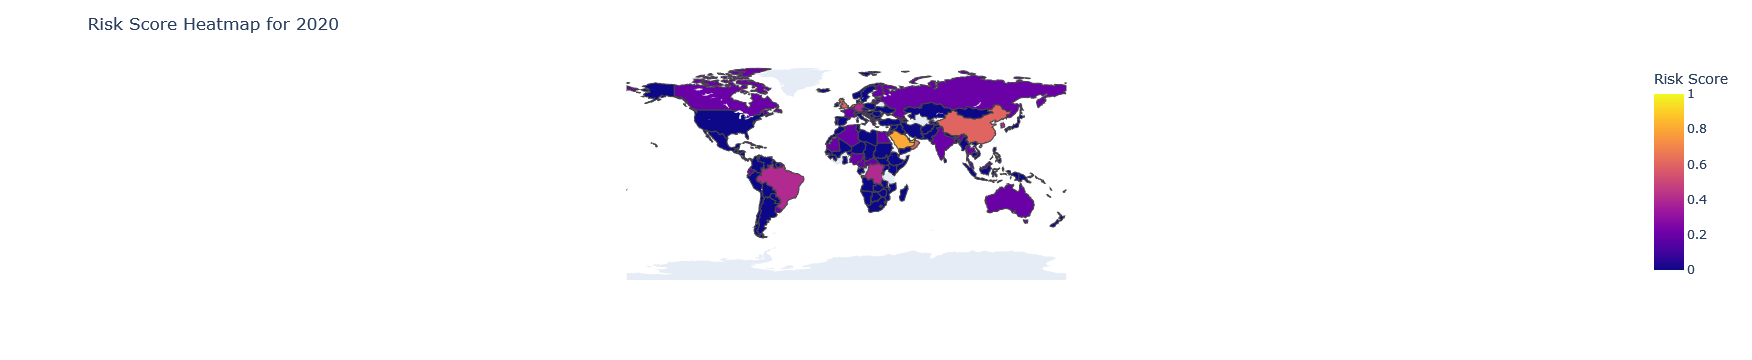

In [51]:
create_heatmap(2020)

# Test Plot for Rendering
If the following plot is not rendering for you then it is most likely an issue with your browser. We tested this on Firefox and Edge and Chrome and noticed that Chrome tended to have the most issues.

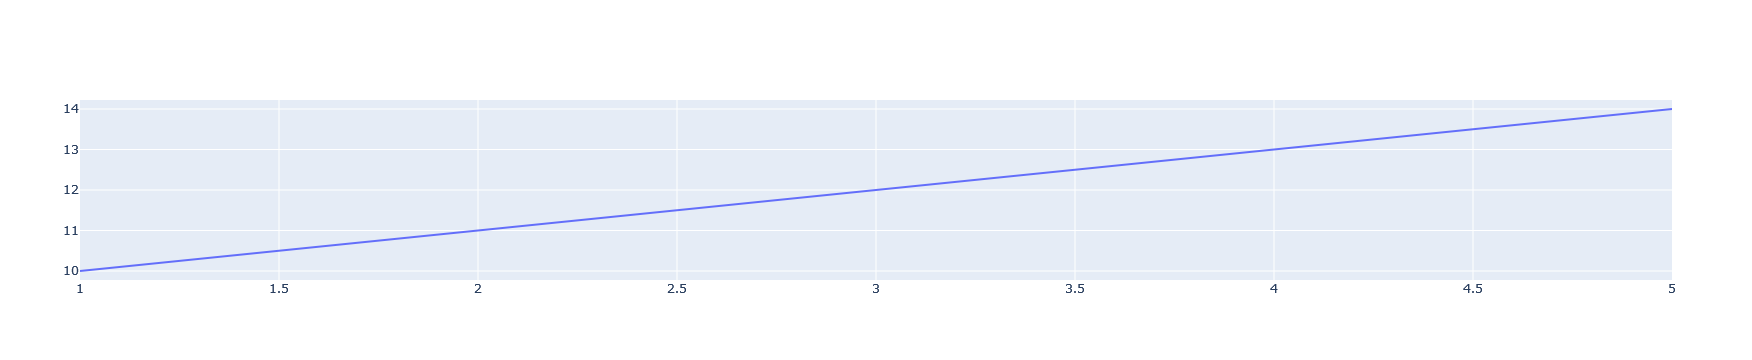

In [52]:
import plotly.graph_objects as go
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

# Sample data
x = [1, 2, 3, 4, 5]
y = [10, 11, 12, 13, 14]

# Create a basic line chart
fig = go.Figure(data=go.Scatter(x=x, y=y, mode='lines'))

# Display the figure
fig.show()


## Test for Widgets

In [53]:
import ipywidgets as widgets
from IPython.display import display

# Example: Slider for years from 2000 to 2020
year_slider = widgets.IntSlider(
    value=2000,
    min=2000,
    max=2020,
    step=1,
    description='Year:',
    continuous_update=False
)

def on_year_change(change):
    print(100)

year_slider.observe(on_year_change, names='value')
display(year_slider)


IntSlider(value=2000, continuous_update=False, description='Year:', max=2020, min=2000)

In [70]:
!pip install ipywidgets


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
